### Goal:
Use scikit-learn's logistic regression to develop a predictive model for blood-brain-barrier penetration

In [78]:
from pip._internal import main as pip

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
    
try:
    import sklearn
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn import metrics
except ImportError:
    pip(['install', 'sklearn'])
    import sklearn
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn import metrics
    
try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('compounds_descriptors.csv', index_col=None)

#### Split the main dataframe into X and Y

In [14]:
X = df.drop(['True', 'SMILES'], axis=1)
Y = df[['True']].replace({'non-penetrating': 0, 'penetrating': 1})

#### Scaling between 0 and 1

In [32]:
X_scaled = (X - X.min()) / (X.max() - X.min())

# remove columns that contain newly generated NaN values (e.g. if some column was constant before scaling)
X_scaled = X_scaled.dropna(axis=1)

X_scaled.head()

#### Select only 20 most important features

In [ ]:
model = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=100) 

rfe = RFE(model, 20, verbose=1)
fit = rfe.fit(X_scaled, Y['True'])

X_rfe = X_scaled.loc[:, fit.support_.tolist()]

#### Cross-validation of logistic regression model

In [75]:
model = LogisticRegressionCV(Cs=100, class_weight=None,
            cv=5, dual=False, fit_intercept=True, intercept_scaling=1.0, 
            max_iter=10000, multi_class='ovr', n_jobs=1, penalty='l1', 
            random_state=None, refit=True, scoring='accuracy', 
            solver='liblinear', tol=0.0001, verbose=0).fit(X_rfe, Y['True'])

# get class predictions
df['Predicted'] = model.predict(X_rfe)

# get probabilities
dfProb = pd.DataFrame(model.predict_proba(X_rfe), columns=['Probability_N', 'Probability_P'])

dfJaqpot = df[['SMILES', 'True', 'Predicted']].replace({0: 'non-penetrating', 1: 'penetrating'})
dfJaqpot = pd.concat([dfJaqpot, dfProb], sort=False, axis=1)

dfJaqpot.to_csv('predictions_Jaqpot.csv', index=False)

#### Evaluate model performance
- confusion matrix
- ROC, AUC

In [76]:
conf = pd.crosstab(dfJaqpot['True'], dfJaqpot['Predicted'])
conf

Predicted,non-penetrating,penetrating
True,,
non-penetrating,90,38
penetrating,25,235


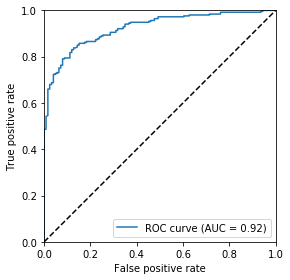

In [79]:
# ROC plot
df = dfJaqpot.copy()

df = df.dropna(axis=0, how='any').drop_duplicates()

df['Probability_diff'] = (df['Probability_P'] - df['Probability_N']) # / 2. + 0.5
df['True'] = df['True'].replace({'penetrating': 1, 'non-penetrating': 0})

# compute ROC
fpr, tpr, thresholds = metrics.roc_curve(df['True'], df['Probability_diff'], pos_label=1)

# compute AUC
auc = metrics.auc(fpr, tpr)

# prepare the plot
fig, ax = plt.subplots(1, 1)

ax.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
ax.plot([0,1], [0,1], label='', color='black', linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

fig.tight_layout()

plt.show()